In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
df=pd.read_csv('3contrat.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Using TensorFlow backend.


Number of rows and columns: (495, 22)


,Time,Close,Price_cny,Price_eur,Price_inr,Price_brl,Price_mxn,sent_china,sent_farm,sent_agri,...,Soybean_Imports,Soybean_Exports,soyoil_imports,soyoil_exports,US_Dollar_Index,RapesPrice,SunflowerPrice,CottonseedPrice,Corn_Price,Fertilizer_Price
0,2017-11-15,985.0000,6.6235,0.8481,65.2700,3.3133,19.2510,-0.5000,0.0000,0.0000,...,1428,337644,3,2,115,377.5000,110,84,338.2500,1269.8700
1,2017-11-16,983.0000,6.6307,0.8496,65.2950,3.2740,19.0590,1.2500,0.0000,0.0000,...,1428,337644,3,2,111,379.0000,103,85,336.5000,1285.4800
2,2017-11-17,996.5000,6.6268,0.8478,65.0150,3.2574,18.9140,0.0000,0.0000,0.0000,...,1428,337644,3,2,101,378.7500,106,90,343.0000,1282.7900
3,2017-11-20,998.5000,6.6350,0.8524,65.1000,3.2574,18.9937,0.0000,0.0000,0.0000,...,1428,337644,3,2,109,375.2500,117,100,345.0000,1282.1600
4,2017-11-21,998.0000,6.6296,0.8519,64.8800,3.2588,18.7745,0.0000,0.0000,0.0000,...,1428,337644,3,2,100,375.7500,127,91,345.0000,1294.3200


In [2]:
df.dtypes

Time                 object
Close               float64
Price_cny           float64
Price_eur           float64
Price_inr           float64
Price_brl           float64
Price_mxn           float64
sent_china          float64
sent_farm           float64
sent_agri           float64
avg_temp            float64
avg_prcp            float64
Soybean_Imports       int64
Soybean_Exports       int64
soyoil_imports        int64
soyoil_exports        int64
US_Dollar_Index       int64
RapesPrice          float64
SunflowerPrice        int64
CottonseedPrice       int64
Corn_Price          float64
Fertilizer_Price    float64
dtype: object

In [20]:
df.head(5)


,Time,Close,Price_cny,Price_eur,Price_inr,Price_brl,Price_mxn,sent_china,sent_farm,sent_agri,...,US_Dollar_Index,RapesPrice,SunflowerPrice,CottonseedPrice,Corn_Price,Fertilizer_Price,year,quarter,month,day
0,2017-11-15,985.0000,6.6235,0.8481,65.2700,3.3133,19.2510,-0.5000,0.0000,0.0000,...,115,377.5000,110,84,338.2500,1269.8700,2017,4,11,15
1,2017-11-16,983.0000,6.6307,0.8496,65.2950,3.2740,19.0590,1.2500,0.0000,0.0000,...,111,379.0000,103,85,336.5000,1285.4800,2017,4,11,16
2,2017-11-17,996.5000,6.6268,0.8478,65.0150,3.2574,18.9140,0.0000,0.0000,0.0000,...,101,378.7500,106,90,343.0000,1282.7900,2017,4,11,17
3,2017-11-20,998.5000,6.6350,0.8524,65.1000,3.2574,18.9937,0.0000,0.0000,0.0000,...,109,375.2500,117,100,345.0000,1282.1600,2017,4,11,20
4,2017-11-21,998.0000,6.6296,0.8519,64.8800,3.2588,18.7745,0.0000,0.0000,0.0000,...,100,375.7500,127,91,345.0000,1294.3200,2017,4,11,21


In [3]:
df['Time'] = pd.to_datetime(df['Time'])
df['year'] = df['Time'].apply(lambda x: x.year)
df['quarter'] = df['Time'].apply(lambda x: x.quarter)
df['month'] = df['Time'].apply(lambda x: x.month)
df['day'] = df['Time'].apply(lambda x: x.day)
df=df.loc[:,['Time','Close', 'year','quarter','month','day']]
df.sort_values('Time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["Time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [7]:
print('The time series starts from: ', df.Time.min())
print('The time series ends on: ', df.Time.max())

The time series starts from:  2017-11-15 00:00:00
The time series ends on:  2019-11-01 00:00:00


In [8]:
stat, p = stats.normaltest(df.Close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=49.652, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.8378035425782784
Skewness of normal distribution: -0.21719033388331357


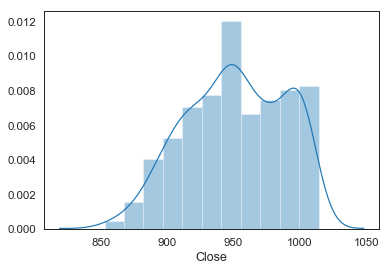

In [9]:
sns.distplot(df.Close);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Close)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Close)))

Kurtosis: describes heaviness of the tails of a distribution.

If the kurtosis is less than zero, then the distribution is light tails.



Skewness: measures asymmetry of the distribution.

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.

If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed.

If the skewness is less than -1 or greater than 1, the data are highly skewed. 

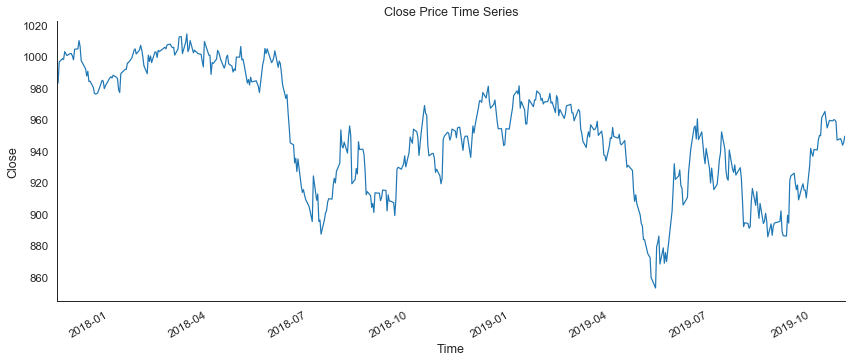

In [10]:
df1=df.loc[:,['Time','Close']]
df1.set_index('Time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Close')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Close Price Time Series')
sns.despine(top=True)
plt.show();

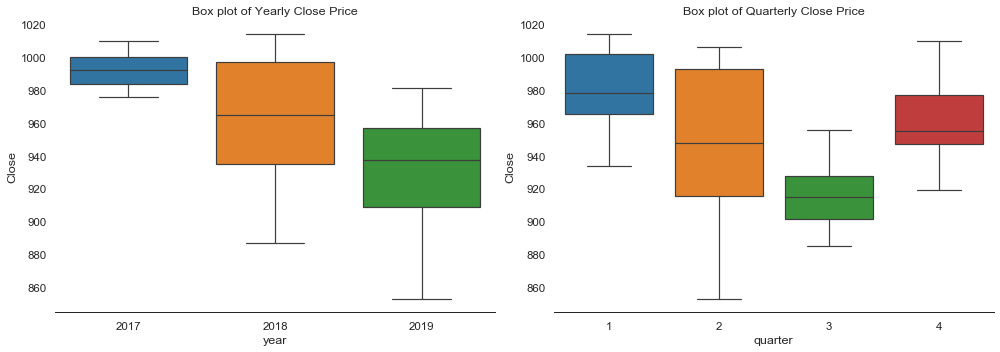

In [26]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Close", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Close Price')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Close", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Close Price')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
Close,495.0000,951.3172,36.9719,852.7500,924.0000,951.0000,983.8750,1014.2500


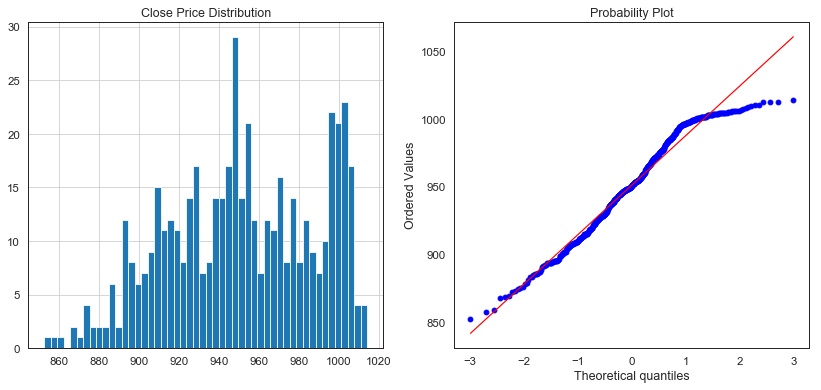

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Close'].hist(bins=50)
plt.title('Close Price Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Close'], plot=plt);
df1.describe().T

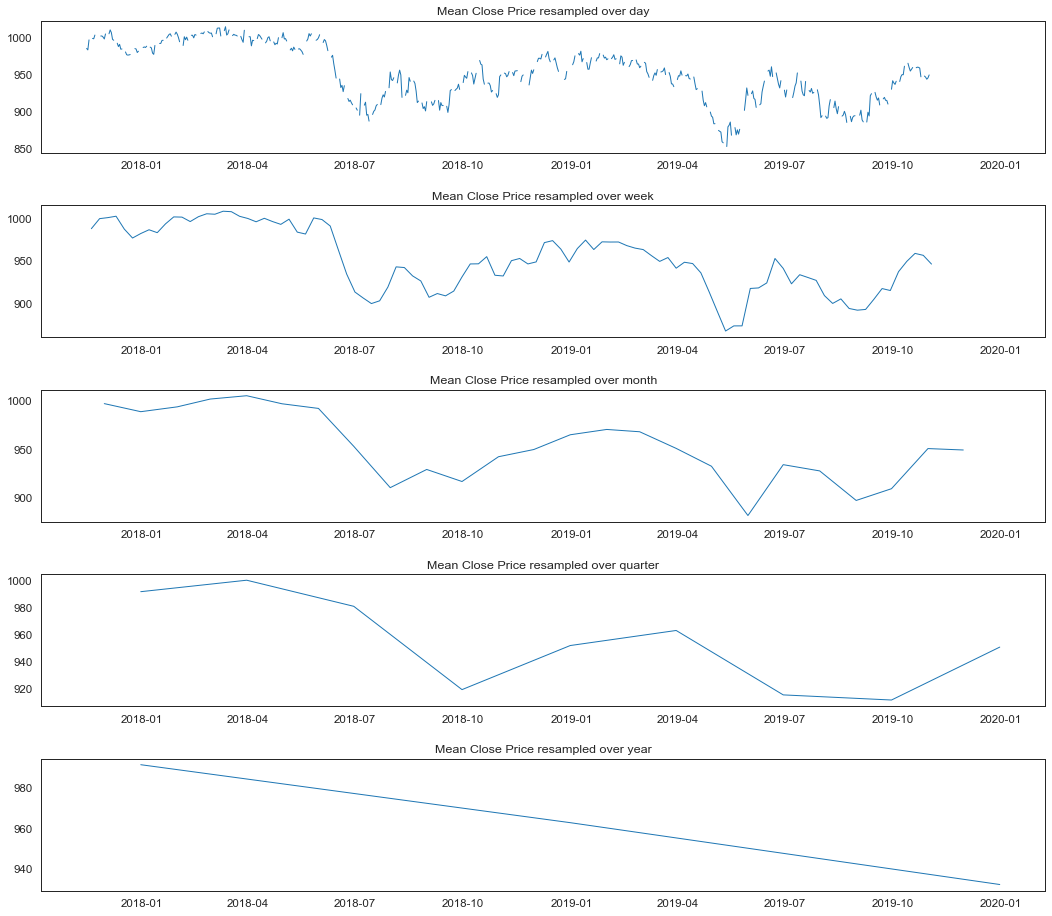

In [31]:
df.index = df.Time
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['Close'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Close Price resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['Close'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Close Price resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['Close'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Close Price resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df['Close'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Close Price resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df['Close'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Close Price resampled over year')
ax5.tick_params(axis='both', which='major');

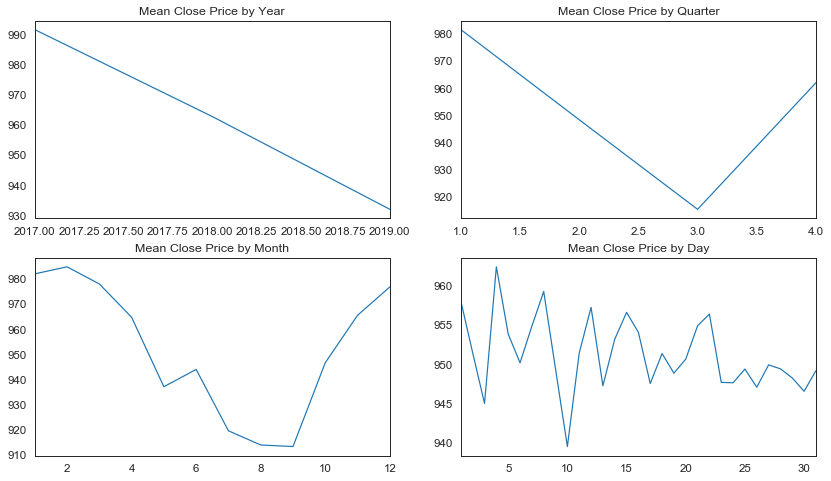

In [32]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Close Price by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Close Price by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Close Price by Month')

plt.subplot(2,2,4)
df.groupby('day').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Close Price by Day');

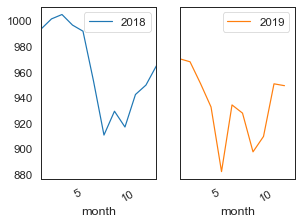

In [34]:
pd.pivot_table(df.loc[df['year'] != 2017], values = "Close", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

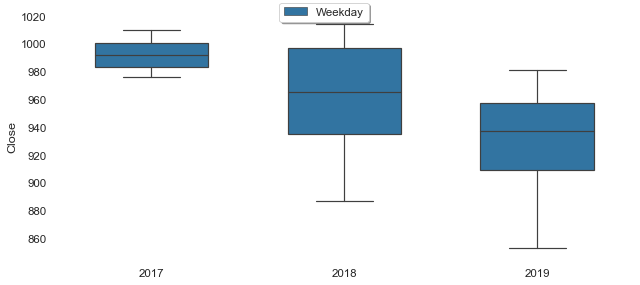

In [35]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Close',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

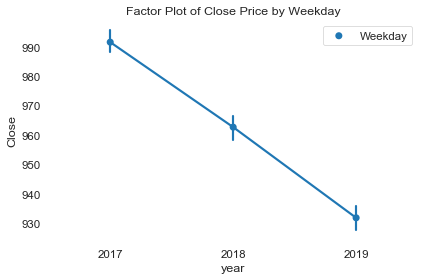

In [37]:
plt1=sns.factorplot('year','Close',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Close Price by Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

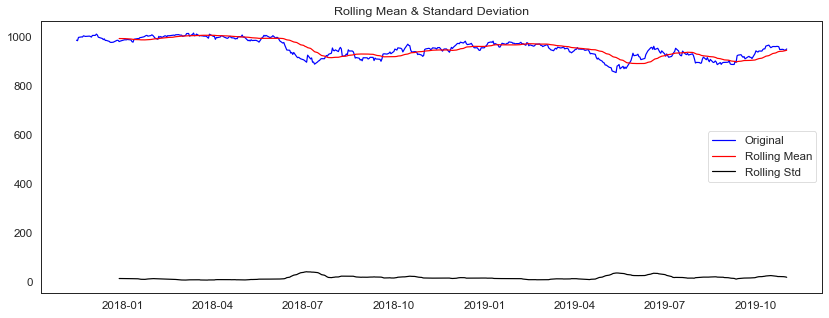

<Results of Dickey-Fuller Test>
Test Statistic                 -2.3672
p-value                         0.1512
#Lags Used                      2.0000
Number of Observations Used   492.0000
Critical Value (1%)            -3.4437
Critical Value (5%)            -2.8674
Critical Value (10%)           -2.5699
dtype: float64


In [39]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Close.dropna())

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

In [72]:
dataset = df.Close.values #numpy.ndarray
dataset = dataset.astype('float32')  #arrary of close price
dataset = np.reshape(dataset, (-1, 1)) #make each close price a list [839,],[900,]
scaler = MinMaxScaler(feature_range=(0, 1))  
dataset = scaler.fit_transform(dataset)  
# 80% 20% split test set and training set
train_size = int(len(dataset) * 0.80)  # 396
test_size = len(dataset) - train_size # 99
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back) # training 
X_test, Y_test = create_dataset(test, look_back) # testing

In [64]:
create_dataset(train, look_back)

(array([[0.8188853 , 0.8065014 , 0.89009285, ..., 0.8993807 , 0.9303403 ,
         0.9148607 ],
        [0.8065014 , 0.89009285, 0.9024768 , ..., 0.9303403 , 0.9148607 ,
         0.92260027],
        [0.89009285, 0.9024768 , 0.8993807 , ..., 0.9148607 , 0.92260027,
         0.92260027],
        ...,
        [0.48916388, 0.42724466, 0.4411764 , ..., 0.4024768 , 0.39318895,
         0.32662535],
        [0.42724466, 0.4411764 , 0.464396  , ..., 0.39318895, 0.32662535,
         0.34829712],
        [0.4411764 , 0.464396  , 0.4024768 , ..., 0.32662535, 0.34829712,
         0.35758495]], dtype=float32),
 array([0.92260027, 0.92260027, 0.91331244, 0.8978329 , 0.9396286 ,
        0.9411764 , 0.9736843 , 0.95046425, 0.89473677, 0.88699675,
        0.8622289 , 0.83436537, 0.85294104, 0.8126936 , 0.8142414 ,
        0.78947353, 0.76625395, 0.76315784, 0.76470566, 0.76780176,
        0.8173375 , 0.8142414 , 0.7848296 , 0.79566574, 0.82662535,
        0.83126926, 0.82662535, 0.837461  , 0.82972145

In [73]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [61]:
X_train.shape

(388, 1, 7)

In [62]:
X_train

array([[[0.8188853 , 0.8065014 , 0.89009285, ..., 0.8993807 ,
         0.9303403 , 0.9148607 ]],

       [[0.8065014 , 0.89009285, 0.9024768 , ..., 0.9303403 ,
         0.9148607 , 0.92260027]],

       [[0.89009285, 0.9024768 , 0.8993807 , ..., 0.9148607 ,
         0.92260027, 0.92260027]],

       ...,

       [[0.48916388, 0.42724466, 0.4411764 , ..., 0.4024768 ,
         0.39318895, 0.32662535]],

       [[0.42724466, 0.4411764 , 0.464396  , ..., 0.39318895,
         0.32662535, 0.34829712]],

       [[0.4411764 , 0.464396  , 0.4024768 , ..., 0.32662535,
         0.34829712, 0.35758495]]], dtype=float32)

In [44]:
create_dataset(train, look_back)

(array([[0.8188853 , 0.8065014 , 0.89009285, ..., 0.8993807 , 0.9303403 ,
         0.9148607 ],
        [0.8065014 , 0.89009285, 0.9024768 , ..., 0.9303403 , 0.9148607 ,
         0.92260027],
        [0.89009285, 0.9024768 , 0.8993807 , ..., 0.9148607 , 0.92260027,
         0.92260027],
        ...,
        [0.48916388, 0.42724466, 0.4411764 , ..., 0.4024768 , 0.39318895,
         0.32662535],
        [0.42724466, 0.4411764 , 0.464396  , ..., 0.39318895, 0.32662535,
         0.34829712],
        [0.4411764 , 0.464396  , 0.4024768 , ..., 0.32662535, 0.34829712,
         0.35758495]], dtype=float32),
 array([0.92260027, 0.92260027, 0.91331244, 0.8978329 , 0.9396286 ,
        0.9411764 , 0.9736843 , 0.95046425, 0.89473677, 0.88699675,
        0.8622289 , 0.83436537, 0.85294104, 0.8126936 , 0.8142414 ,
        0.78947353, 0.76625395, 0.76315784, 0.76470566, 0.76780176,
        0.8173375 , 0.8142414 , 0.7848296 , 0.79566574, 0.82662535,
        0.83126926, 0.82662535, 0.837461  , 0.82972145

In [69]:
X_train.shape

(388, 1, 7)

In [74]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=120, batch_size=15, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()
# train data

Train on 388 samples, validate on 91 samples
Epoch 1/120
388/388 [==============================] - 1s 2ms/step - loss: 0.4916 - val_loss: 0.0886
Epoch 2/120
388/388 [==============================] - 0s 131us/step - loss: 0.1197 - val_loss: 0.0616
Epoch 3/120
388/388 [==============================] - 0s 119us/step - loss: 0.0740 - val_loss: 0.0615
Epoch 4/120
388/388 [==============================] - 0s 115us/step - loss: 0.0669 - val_loss: 0.0599
Epoch 5/120
388/388 [==============================] - 0s 115us/step - loss: 0.0685 - val_loss: 0.0580
Epoch 6/120
388/388 [==============================] - 0s 130us/step - loss: 0.0668 - val_loss: 0.0556
Epoch 7/120
388/388 [==============================] - 0s 110us/step - loss: 0.0681 - val_loss: 0.0560
Epoch 8/120
388/388 [==============================] - 0s 106us/step - loss: 0.0635 - val_loss: 0.0538
Epoch 9/120
388/388 [==============================] - 0s 110us/step - loss: 0.0645 - val_loss: 0.0526
Epoch 10/120
388/388 [========

388/388 [==============================] - 0s 104us/step - loss: 0.0443 - val_loss: 0.0410
Epoch 80/120
388/388 [==============================] - 0s 107us/step - loss: 0.0459 - val_loss: 0.0408
Epoch 81/120
388/388 [==============================] - 0s 104us/step - loss: 0.0446 - val_loss: 0.0406
Epoch 82/120
388/388 [==============================] - 0s 105us/step - loss: 0.0419 - val_loss: 0.0406
Epoch 83/120
388/388 [==============================] - 0s 106us/step - loss: 0.0421 - val_loss: 0.0419
Epoch 84/120
388/388 [==============================] - 0s 103us/step - loss: 0.0424 - val_loss: 0.0404
Epoch 85/120
388/388 [==============================] - 0s 100us/step - loss: 0.0413 - val_loss: 0.0418
Epoch 86/120
388/388 [==============================] - 0s 101us/step - loss: 0.0463 - val_loss: 0.0408
Epoch 87/120
388/388 [==============================] - 0s 99us/step - loss: 0.0459 - val_loss: 0.0406
Model: "sequential_1"
________________________________________________________

In [75]:
#make prediction
train_predict = model.predict(X_train)  
test_predict = model.predict(X_test)  
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 5.569344626517569
Train Root Mean Squared Error: 7.498574295488622
Test Mean Absolute Error: 6.550505223110931
Test Root Mean Squared Error: 8.40227413252618


In [81]:
Y_test

array([[944.24996225, 936.75003595, 931.7499824 , 941.4999636 ,
        928.75001188, 919.49997443, 928.99998376, 915.24999052,
        918.7499818 , 925.74996435, 934.25000917, 938.49999308,
        952.00001444, 941.00001985, 927.4999985 , 922.50002196,
        921.25000857, 940.4999991 , 928.24999113, 926.24998511,
        930.99998977, 924.50002798, 925.74996435, 929.25003264,
        922.24997308, 908.49997985, 891.75001609, 894.24996586,
        893.75002211, 890.74997458, 891.75001609, 907.50001534,
        915.99998315, 905.25003745, 913.99997714, 903.74997518,
        896.9999645 , 906.49997383, 893.75002211, 895.25000737,
        900.24998391, 895.49997924, 885.24997729, 893.49997323,
        886.2500188 , 891.99998797, 893.99999398, 894.24996586,
        895.0000355 , 901.74996917, 888.74996856, 885.99996992,
        885.74999804, 898.99997052, 893.99999398, 921.25000857,
        924.00000722, 925.74996435, 919.49997443, 915.24999052,
        918.25003805, 908.75002873, 917.

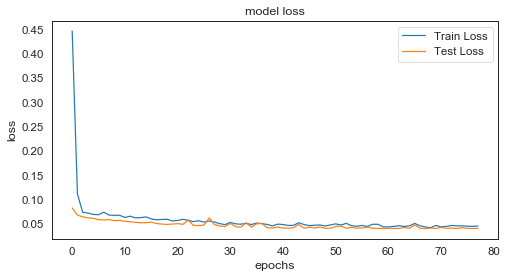

In [97]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

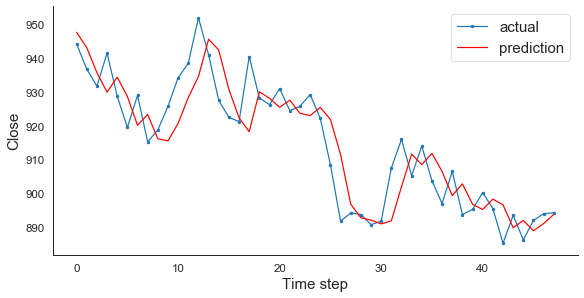

In [98]:
aa=[x for x in range(48)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:48], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:48], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [46]:
Y_test

array([[929.25003264, 922.24997308, 908.49997985, 891.75001609,
        894.24996586, 893.75002211, 890.74997458, 891.75001609,
        907.50001534, 915.99998315, 905.25003745, 913.99997714,
        903.74997518, 896.9999645 , 906.49997383, 893.75002211,
        895.25000737, 900.24998391, 895.49997924, 885.24997729,
        893.49997323, 886.2500188 , 891.99998797, 893.99999398,
        894.24996586, 895.0000355 , 901.74996917, 888.74996856,
        885.99996992, 885.74999804, 898.99997052, 893.99999398,
        921.25000857, 924.00000722, 925.74996435, 919.49997443,
        915.24999052, 918.25003805, 908.75002873, 917.00002467,
        919.00003068, 915.00001865, 915.00001865, 909.99996511,
        930.00002527, 941.4999636 , 938.49999308, 936.49998706,
        940.74997097, 940.4999991 , 947.0000379 , 949.75003655,
        949.49998767, 961.00000301, 965.00001504, 959.24996887,
        954.4999642 , 956.99999098, 959.24996887, 958.99999699,
        959.74998962, 959.50001775, 958.